# MedInfo 2019 Practical 2
****
In this practical session, using the same data as practical 1, we will explore some of the concepts covered in the lectures and give you the opportunity to run some code.  


In this practical session you will explore how to fit a prediction model for time to event data.

We will use the same data set used for practical 1 but rather than modelling if the event happened in 2 years, we will consider any event during the whole follow up in the data (9.5 years) and the time at which it occured.  

Due to limited time, we will only consider cox proportional hazard models as they are one of the most common types of survival models used and we will not cover checking the models assumptions, such as proportional hazards, and what to do if the assumptions do not hold.

Note: Other models, including non-parametric or weibull survival models could be more appropriate to use depending on your data and this is something that should also be considered and tested when developing a prediction model.



### Lets begin

First lets load the packages we will be using in the practical

In [1]:
library(ggplot2)
library(plyr)
library(rms)
library(reshape2)
library(prodlim)
library(muhaz)
library(survival)
library(Hmisc)
library(survminer)
library(MASS)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'rms' was built under R version 3.6.1"Loading required package: Hmisc
Warning message:
"package 'Hmisc' was built under R version 3.6.1"Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:plyr':

    is.discrete, summarize

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: SparseM

Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve

Warning message:
"package 'muhaz' was built under R version 3.6.1"Warning message:
"package 'survminer' was built under R version 3.6.1"Loading required package: ggpubr
Warning message:
"package 'ggpubr' was built under R version 3.6.1"Loading required package: magrittr


## Part 1
Load the data (smart) as we did in practical 1. The "Data/SMARTs_medinfo_P2-4.rds" file is the same data as before but albumin is already a categorical variable and the SBP variable has already been generated

Begin by loading the data and conducting a brief data check

In [2]:
smart <- readRDS("SMARTs_medinfo_P2-4.rds")
attach(smart)
class(smart)
sapply(smart,class)
dim(smart)

[1] "data.frame"

TEVENT     EVENT       SEX       AGE  DIABETES  CEREBRAL   CARDIAC       AAA 
"numeric" "integer"  "factor" "integer"  "factor"  "factor"  "factor"  "factor" 
   PERIPH  STENOSIS   LENGTHO   WEIGHTO      BMIO     CHOLO   albumin   SMOKING 
 "factor"  "factor" "numeric" "integer" "numeric" "numeric" "integer"  "factor" 
  packyrs   alcohol   outcome       SBP 
"numeric"  "factor" "integer" "integer"

[1] 3873   20

In [3]:
sapply(smart,summary)

$TEVENT
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.1   555.0  1213.0  1370.3  2165.0  3466.0 

$EVENT
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1188  0.0000  1.0000 

$SEX
Female   Male 
   976   2897 

$AGE
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   52.00   60.00   59.56   68.00   82.00 

$DIABETES
   0    1 NA's 
2987  846   40 

$CEREBRAL
   0    1 
2726 1147 

$CARDIAC
   0    1 
1713 2160 

$AAA
   0    1 
3457  416 

$PERIPH
   0    1 
2933  940 

$STENOSIS
   0    1 NA's 
3058  722   93 

$LENGTHO
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.42    1.68    1.75    1.74    1.80    2.05       1 

$WEIGHTO
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  37.00   72.00   80.00   81.01   89.00  143.00       2 

$BMIO
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  15.43   24.11   26.30   26.70   28.73   48.85       3 

$CHOLO
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.

In [4]:
summary(smart$TEVENT) # Summarises the time to event
table(smart$EVENT) # Tabulates number of events
table(smart$EVENT==1, round(smart$TEVENT/365,0)) # Tabulates number of events by year (TRUE=event, FALSE=censored)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.1   555.0  1213.0  1370.3  2165.0  3466.0 


   0    1 
3413  460 

       
          0   1   2   3   4   5   6   7   8   9
  FALSE 258 514 497 447 354 305 333 314 241 150
  TRUE   88  98  54  63  51  38  30  24  10   4

## Part 2 
### Survival objects and Kaplan-Meier plots

We will now use R to illustrate 1) how to handle survival data, 2) how to illustrate it using the Kaplan-Meier estimate, and 3) how to build a cox proportional hazard regression model.

The columns of interest (for now) in the data are ‘TEVENT’ and ‘EVENT’.

‘survival’ is the R package that contains most of the functions we need to conduct survival analysis.
First, we need to tell R that ‘TEVENT’ and ‘EVENT’ are a pair that define the outcome, using a special function ‘Surv’:

In [5]:
TE<-Surv(TEVENT,EVENT)

This ‘Surv object’ is then used as our outcome in subsequent code. For example, we can construct a Kaplan Meier estimate:

In [6]:
KM<-survfit(TE~1, data = smart)

This calculates the Kaplan-Meier estimate at all possible values of _t_ (note that the estimate only changes when events are observed). Note that ‘survfit’ we have specified a formula, and the ‘1’ means there are no covariates. More on this later.

We can also plot the Kaplan-Meier estimate:

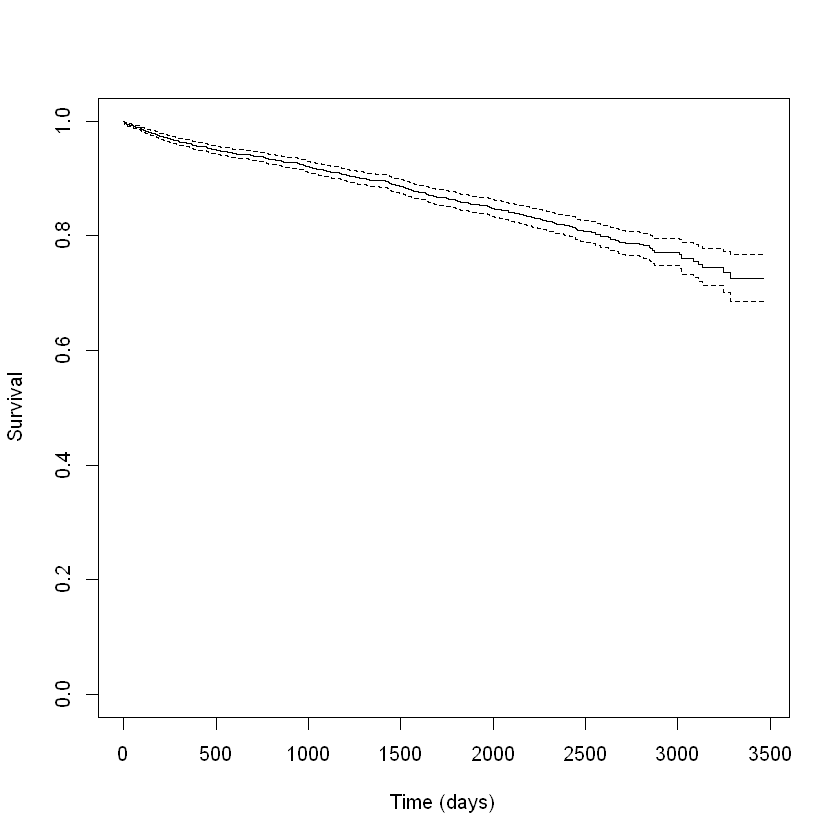

In [7]:
plot(KM,xlab="Time (days)",ylab="Survival")

We can also plot this in months (using TEVENT/12) or years (using TEVENT/365.25)

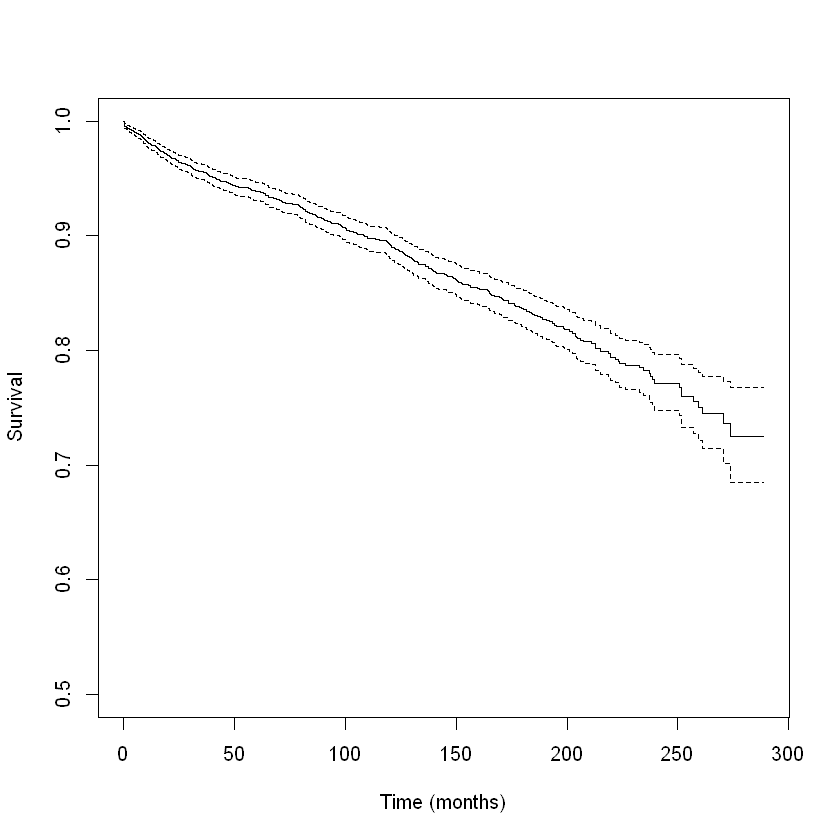

In [8]:
TEmth<-Surv(TEVENT/12,EVENT)
KMmth<-survfit(TEmth~1, data = smart)
plot(KMmth,xlab="Time (months)",ylab="Survival", ylim = c(0.5,1))

Interpretation of the plot: we see a steady decline in the survival function over time. By the end of follow-up we estimate that approximatly 25% of the patients have had the event.

### Stratified Kaplan-Meier Estimates
We can also consider plotting survival estimates across different **categorical** variables. Producing Kaplan Meier estimates separately in the groups, and plotting these on the same graph. This is a good way to get a descriptive idea of the effect of the variable on time to event. We will start by looking at the association between gender:

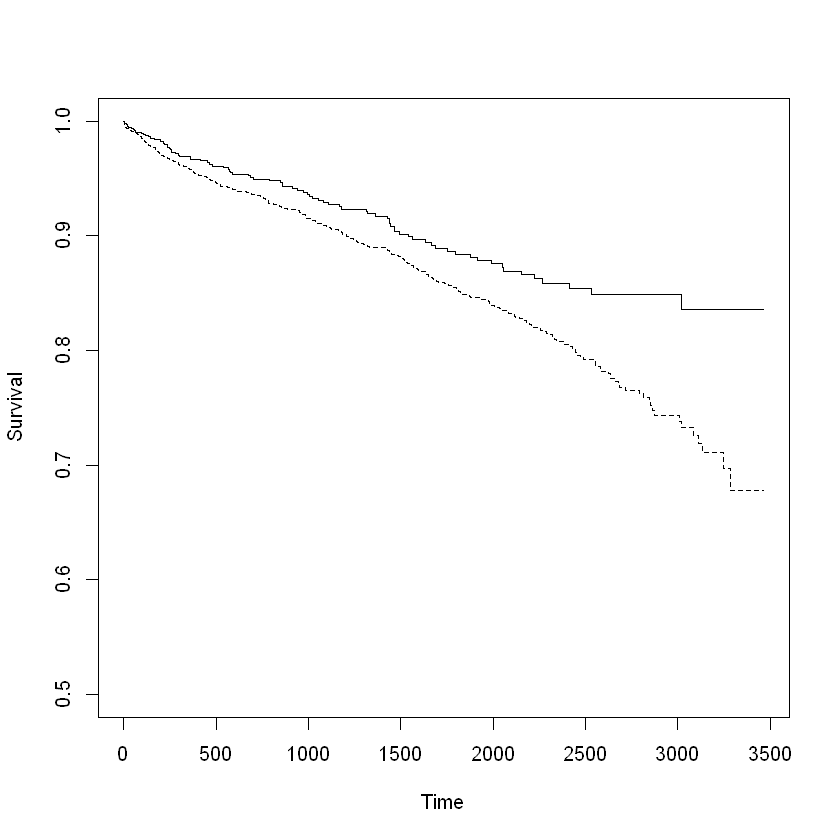

In [9]:
KM <-survfit(TE~SEX, data = smart)

plot(KM,lty=1:2,xlab="Time",ylab="Survival", ylim = c(0.5,1))

#ggsurvplot(KM, data = smart, risk.table = TRUE, ylim = c(0.5,1))

Here, we can see there there appears to be some difference in the survival curves, particularly at later follow-up. The log-rank test is a means to formally test the hypothesis that survival differs between the two groups. We can perform this test in R by:

In [10]:
survdiff(TE~SEX, data = smart)

Call:
survdiff(formula = TE ~ SEX, data = smart)

              N Observed Expected (O-E)^2/E (O-E)^2/V
SEX=Female  976       86      117      8.14      10.9
SEX=Male   2897      374      343      2.77      10.9

 Chisq= 10.9  on 1 degrees of freedom, p= 9e-04 

From the R output we see that P<0.001 and we therefore reject the null hypothesis that the survival curves are the same.

**By modifying the above code, explore the effect of other variables on survival. Remember, that you might need to categorise continuous variables**

In [11]:
#Enter R code here

## Part 3
Now lets begin by fitting univariable models with categorical variables

In [12]:
cox_sex <- coxph(Surv(TEVENT/12,EVENT)~SEX)
summary(cox_sex)

cox_card <- coxph(Surv(TEVENT/12,EVENT)~CARDIAC)
summary(cox_card)

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ SEX)

  n= 3873, number of events= 460 

          coef exp(coef) se(coef)     z Pr(>|z|)   
SEXMale 0.3933    1.4818   0.1197 3.286  0.00102 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
SEXMale     1.482     0.6749     1.172     1.874

Concordance= 0.527  (se = 0.01 )
Likelihood ratio test= 11.68  on 1 df,   p=6e-04
Wald test            = 10.8  on 1 df,   p=0.001
Score (logrank) test = 10.93  on 1 df,   p=9e-04


Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ CARDIAC)

  n= 3873, number of events= 460 

            coef exp(coef) se(coef)     z Pr(>|z|)
CARDIAC1 0.02270   1.02296  0.09386 0.242    0.809

         exp(coef) exp(-coef) lower .95 upper .95
CARDIAC1     1.023     0.9776    0.8511      1.23

Concordance= 0.499  (se = 0.013 )
Likelihood ratio test= 0.06  on 1 df,   p=0.8
Wald test            = 0.06  on 1 df,   p=0.8
Score (logrank) test = 0.06  on 1 df,   p=0.8


The hazard ratio for the model including sex is 1.482 (95% confidence interval: 1.172-1.874). Hence, men have a 1.482 fold increase in their risk of experienceing the event compared to women. Pr(>|z|) (p-value) represents the the probability that the model coefficient is zero.  
Note: this is not causal and is subject to confounding. Adjusting for additional predictors will lkely change this estimate (see results at the end of the practical)

## Part 4
Modelling using splines
Similar to logistic regression models we can investigate if a continuous variables shpuld be modelled as a linear or non-linear association with with outcome of interest.

First create spline variables, where 3 means 3 knots (i.e. 2 age terms) etc.

In [13]:
age3_spline <- rcs(AGE,3)
age4_spline <- rcs(AGE,4)
age5_spline <- rcs(AGE,5)


Fit a cox regression model using each set of spline variables & predict the linear predictor (LP). 

In [14]:

# Fit a Cox model for each spline function
cox_age3 <- coxph(Surv(TEVENT/12,EVENT)~age3_spline,data=smart,ties="breslow")
cox_age3
lp_age3 <- predict(cox_age3)

cox_age4 <- coxph(Surv(TEVENT/12,EVENT)~age4_spline,data=smart,ties="breslow")
cox_age4
lp_age4 <- predict(cox_age4)

cox_age5 <- coxph(Surv(TEVENT/12,EVENT)~age5_spline,data=smart,ties="breslow")
cox_age5
lp_age5 <- predict(cox_age5)

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ age3_spline, data = smart, 
    ties = "breslow")

                    coef exp(coef) se(coef)     z        p
age3_splineAGE  0.008113  1.008146 0.012010 0.676 0.499309
age3_splineAGE' 0.046496  1.047594 0.012817 3.628 0.000286

Likelihood ratio test=118.1  on 2 df, p=< 2.2e-16
n= 3873, number of events= 460 

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ age4_spline, data = smart, 
    ties = "breslow")

                      coef exp(coef)  se(coef)      z     p
age4_splineAGE    0.001549  1.001550  0.019343  0.080 0.936
age4_splineAGE'   0.054747  1.056274  0.042725  1.281 0.200
age4_splineAGE'' -0.071218  0.931259  0.188684 -0.377 0.706

Likelihood ratio test=118.4  on 3 df, p=< 2.2e-16
n= 3873, number of events= 460 

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ age5_spline, data = smart, 
    ties = "breslow")

                        coef  exp(coef)   se(coef)      z     p
age5_splineAGE    -0.0004737  0.9995264  0.0242917 -0.020 0.984
age5_splineAGE'    0.0674447  1.0697711  0.1017985  0.663 0.508
age5_splineAGE''  -0.1006972  0.9042068  0.5500061 -0.183 0.855
age5_splineAGE'''  0.0509447  1.0522647  0.9209874  0.055 0.956

Likelihood ratio test=118.4  on 4 df, p=< 2.2e-16
n= 3873, number of events= 460 

We alo need to non-spline model


In [15]:
cox_age <- coxph(Surv(TEVENT/12,EVENT)~AGE)
summary(cox_age)
lp_age1 <- predict(cox_age)

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ AGE)

  n= 3873, number of events= 460 

        coef exp(coef) se(coef)     z Pr(>|z|)    
AGE 0.049664  1.050918 0.005038 9.858   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

    exp(coef) exp(-coef) lower .95 upper .95
AGE     1.051     0.9515     1.041     1.061

Concordance= 0.624  (se = 0.015 )
Likelihood ratio test= 105.9  on 1 df,   p=<2e-16
Wald test            = 97.17  on 1 df,   p=<2e-16
Score (logrank) test = 99.32  on 1 df,   p=<2e-16


Plot all LP together for visual inspection

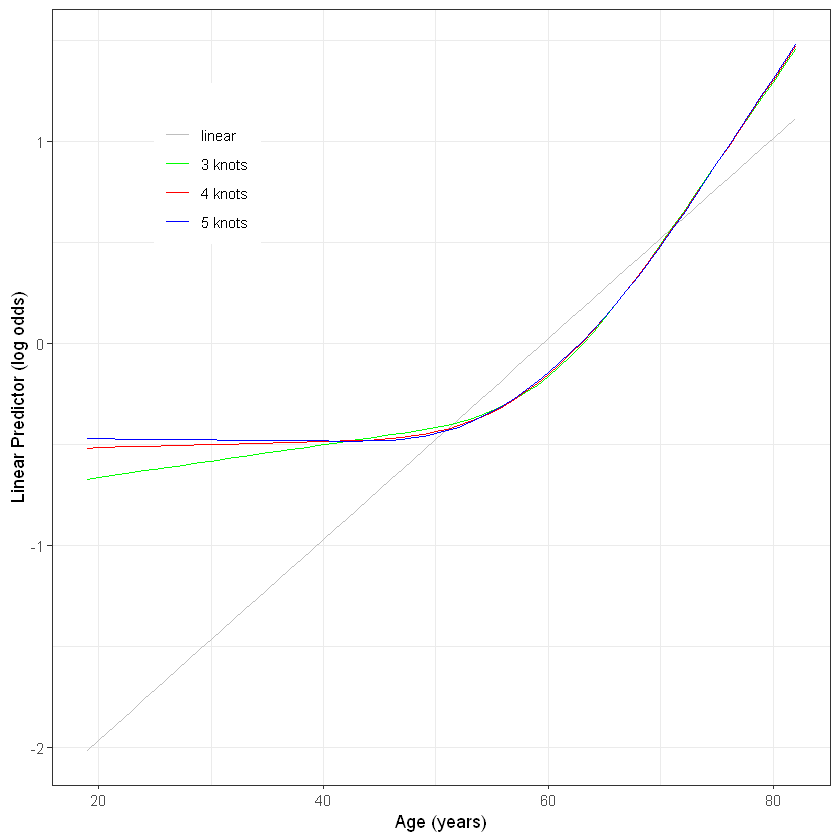

In [16]:
data_part6 <- data.frame(AGE,lp_age1,lp_age3,lp_age4,lp_age5)
data_part6_m <- melt(data_part6,id.vars='AGE')
plot_part6 <- ggplot(data_part6_m,aes(AGE,value,colour=variable))+geom_line()+scale_colour_manual(labels=c("linear","3 knots","4 knots","5 knots"),values=c("gray","green","red","blue"))+theme_bw()
plot_part6 + labs(x="Age (years)",y="Linear Predictor (log odds)",color="") + theme(legend.position=c(0.2,0.8))

In [17]:
age_spline_check <- matrix(c(AIC(cox_age),
         BIC(cox_age),
         AIC(cox_age3),
         BIC(cox_age3),
         AIC(cox_age4),
         BIC(cox_age4),
         AIC(cox_age5),
         BIC(cox_age5)), ncol=2, byrow=TRUE)

colnames(age_spline_check) <- c("AIC", "BIC")
rownames(age_spline_check) <- c("age_mod","age3_mod", "age4_mod", "age5_mod")
age_spline_check

,AIC,BIC
age_mod,6905.645,6909.776
age3_mod,6895.507,6903.770
age4_mod,6897.222,6909.615
age5_mod,6899.181,6915.706


**Using the plot of the spline functions and the table above, which age term would you use (how many knots)?**

## Part 5 Building a multivariable model

Similar to practical 1, we will now select the same predictor variables of interest and build a multivariable cox model using stepwise selection.

In [18]:
detach(smart)
smart <- subset(smart, select = c(outcome, TEVENT, EVENT, SEX, AGE, SBP, alcohol, CHOLO, BMIO, DIABETES, CARDIAC, SMOKING, AAA))
smart <- na.omit(smart)
age3_spline <- rcs(smart$AGE,3)
attach(smart)

In [19]:

k10 <- qchisq(0.10,1,lower.tail=FALSE) # this gives the change in AIC we consider to be significant in our stepwise selection

# Forward selection (by AIC)
empty_mod_2 <- coxph(Surv(TEVENT/12,EVENT)~1)
forward_mod_2 <- stepAIC(empty_mod_2,k=k10,scope=list(upper=~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,lower=~1),direction="forward",trace=TRUE)


Start:  AIC=6853.54
Surv(TEVENT/12, EVENT) ~ 1

              Df    AIC
+ age3_spline  2 6741.7
+ AAA          1 6799.5
+ SBP          1 6831.9
+ SEX          1 6843.5
+ DIABETES     1 6844.6
+ BMIO         1 6851.8
+ alcohol      2 6852.4
<none>           6853.5
+ SMOKING      2 6855.1
+ CHOLO        1 6856.2
+ CARDIAC      1 6856.2

Step:  AIC=6741.65
Surv(TEVENT/12, EVENT) ~ age3_spline

           Df    AIC
+ AAA       1 6715.5
+ SEX       1 6730.3
+ SMOKING   2 6736.6
+ DIABETES  1 6738.2
<none>        6741.7
+ SBP       1 6742.4
+ BMIO      1 6743.1
+ CARDIAC   1 6743.5
+ alcohol   2 6744.3
+ CHOLO     1 6744.3

Step:  AIC=6715.49
Surv(TEVENT/12, EVENT) ~ age3_spline + AAA

           Df    AIC
+ SEX       1 6709.2
+ DIABETES  1 6709.4
+ SMOKING   2 6714.6
+ SBP       1 6715.1
<none>        6715.5
+ CARDIAC   1 6716.1
+ BMIO      1 6717.4
+ CHOLO     1 6718.2
+ alcohol   2 6718.5

Step:  AIC=6709.24
Surv(TEVENT/12, EVENT) ~ age3_spline + AAA + SEX

           Df    AIC
+ DIABETES

In [20]:
# Backward selection (by AIC)
full_mod_2 <- coxph(Surv(TEVENT/12,EVENT)~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA)
backward_mod_2 <- stepAIC(full_mod_2,k=k10,scope=list(upper=~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,lower=~1),direction="backward",trace=TRUE)


Start:  AIC=6707.16
Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + SBP + alcohol + 
    CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA

              Df    AIC
- CHOLO        1 6704.7
- alcohol      2 6707.0
- CARDIAC      1 6707.0
<none>           6707.2
- SBP          1 6707.2
- BMIO         1 6707.3
- SMOKING      2 6707.3
- SEX          1 6712.4
- DIABETES     1 6713.7
- AAA          1 6729.3
- age3_spline  2 6768.7

Step:  AIC=6704.67
Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + SBP + alcohol + 
    BMIO + DIABETES + CARDIAC + SMOKING + AAA

              Df    AIC
- CARDIAC      1 6704.4
- alcohol      2 6704.6
<none>           6704.7
- BMIO         1 6704.8
- SBP          1 6704.9
- SMOKING      2 6705.0
- SEX          1 6709.7
- DIABETES     1 6711.1
- AAA          1 6726.9
- age3_spline  2 6766.0

Step:  AIC=6704.39
Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + SBP + alcohol + 
    BMIO + DIABETES + SMOKING + AAA

              Df    AIC
- SBP          1 6703.9
- BMIO         

In [24]:
summary(forward_mod_2)
summary(backward_mod_2)

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ age3_spline + AAA + 
    SEX + DIABETES)

  n= 3803, number of events= 451 

                        coef  exp(coef)   se(coef)      z Pr(>|z|)    
age3_splinesmart  -0.0006377  0.9993625  0.0121099 -0.053 0.958005    
age3_splinesmart'  0.0496738  1.0509282  0.0129216  3.844 0.000121 ***
AAA1               0.6227670  1.8640789  0.1156473  5.385 7.24e-08 ***
SEXMale            0.3682295  1.4451737  0.1233351  2.986 0.002830 ** 
DIABETES1          0.3347327  1.3975667  0.1062202  3.151 0.001625 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                  exp(coef) exp(-coef) lower .95 upper .95
age3_splinesmart     0.9994     1.0006    0.9759     1.023
age3_splinesmart'    1.0509     0.9515    1.0246     1.078
AAA1                 1.8641     0.5365    1.4860     2.338
SEXMale              1.4452     0.6920    1.1348     1.840
DIABETES1            1.3976     0.7155    1.1349     1.721

Concordance= 0.652  (se = 0

Call:
coxph(formula = Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + 
    alcohol + DIABETES + SMOKING + AAA)

  n= 3803, number of events= 451 

                       coef exp(coef)  se(coef)      z Pr(>|z|)    
SEXMale            0.378591  1.460226  0.128945  2.936  0.00332 ** 
age3_splinesmart  -0.002059  0.997944  0.012107 -0.170  0.86499    
age3_splinesmart'  0.051823  1.053190  0.013015  3.982 6.84e-05 ***
alcoholFormer      0.164806  1.179164  0.145426  1.133  0.25710    
alcoholNever       0.276156  1.318054  0.119090  2.319  0.02040 *  
DIABETES1          0.328192  1.388455  0.106728  3.075  0.00210 ** 
SMOKINGFormer      0.038336  1.039081  0.199952  0.192  0.84796    
SMOKINGNever      -0.292658  0.746277  0.233734 -1.252  0.21053    
AAA1               0.586621  1.797904  0.116823  5.021 5.13e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                  exp(coef) exp(-coef) lower .95 upper .95
SEXMale              1.4602     0.6848    1.1341 

Remember the logistic model in practical 1 choose age, AAA and diabetes as significant predictors and we forced sex to be in the final model. Here, sex was chosen as a significant predictor in both the forward and backward selection approachs.  
Backward selection also included alcohol and smoking as predictors in the final model. As disscussed in practical 1, forward and backward selection do not always chose the same final model and we need to be careful when building our model.

For the stepwise selection we have been using a p-value of 0.1 (equivalent to an AIC of 2.706) so not to be too stringent. However, if we change this to 0.05 we can end with a different model. Lets try this in backward selection....

In [22]:
k10 <- qchisq(0.05,1,lower.tail=FALSE)

full_mod_2 <- coxph(Surv(TEVENT/12,EVENT)~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA)
backward_mod_2a <- stepAIC(full_mod_2,k=k10,scope=list(upper=~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,lower=~1),direction="backward",trace=TRUE)


Start:  AIC=6721.92
Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + SBP + alcohol + 
    CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA

              Df    AIC
- CHOLO        1 6718.3
- alcohol      2 6719.5
- SMOKING      2 6719.8
- CARDIAC      1 6720.7
- SBP          1 6720.9
- BMIO         1 6720.9
<none>           6721.9
- SEX          1 6726.0
- DIABETES     1 6727.3
- AAA          1 6742.9
- age3_spline  2 6781.2

Step:  AIC=6718.3
Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + SBP + alcohol + 
    BMIO + DIABETES + CARDIAC + SMOKING + AAA

              Df    AIC
- alcohol      2 6715.9
- SMOKING      2 6716.3
- CARDIAC      1 6716.9
- BMIO         1 6717.3
- SBP          1 6717.4
<none>           6718.3
- SEX          1 6722.2
- DIABETES     1 6723.5
- AAA          1 6739.4
- age3_spline  2 6777.4

Step:  AIC=6715.94
Surv(TEVENT/12, EVENT) ~ SEX + age3_spline + SBP + BMIO + DIABETES + 
    CARDIAC + SMOKING + AAA

              Df    AIC
- SMOKING      2 6712.8
- CARDIAC      1

Smoking and alcohol have not been included in this model. From the previous model we can see they are boarderline significant and so choosing a stringent p-value to build a model is often not the most appropriate as you can miss potentilly important predictors.  

In this practical we have built a model solely based on statistical results. However, in practice it is advised that both statistical and clinical relevance should be used to build a model. It is advised to build a model using clinical input and include variables that are clinically important even if the predictor does not appear statistically significant in the model